<a href="https://colab.research.google.com/github/sirishshresthas/openai-function-calling/blob/main/OpenAI_Function_Calling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install openai simple_colors --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.9/262.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00


In [6]:
from google.colab import userdata
from pprint import pprint
from openai import OpenAI
from simple_colors import *
import json

Create an OpenAI API Key from https://platform.openai.com/api-keys

In [8]:
MODEL = 'gpt-3.5-turbo-1106'
client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY')
)

# Using Chat Completion

In [9]:
prompt = "What is the population and capital of Djibouti? Return the response as JSON objec."


In [30]:
response = client.chat.completions.create(
    model = MODEL,
    messages = [{
        "role": "user",
        "content": prompt
    }],
    # response_format={"type": "json_object"} ## only supported in >= gpt-3.5-turbo-1106
)

In [29]:
pprint(response.choices[0].message.content)

('The population of the United States is approximately 331 million and the '
 'capital city is Washington, D.C.')


In [14]:
prompt = "What is the population and capital of Finland? Return the response as JSON objec."


In [15]:
response = client.chat.completions.create(
    model = MODEL,
    messages = [{
        "role": "user",
        "content": prompt
    }],
    response_format={"type": "json_object"} ## only supported in >= gpt-3.5-turbo-1106
)

In [16]:
pprint(response.choices[0].message.content)

'{\n  "population": "5.5 million",\n  "capital": "Helsinki"\n}'


In [17]:
prompt = "What is the population and capital of US?"

In [18]:
response = client.chat.completions.create(
    model = MODEL,
    messages = [{
        "role": "user",
        "content": prompt
    }],
    # response_format={"type": "json_object"} ## only supported in >= gpt-3.5-turbo-1106
)

In [19]:
pprint(response.choices[0].message.content)

('The population of the United States is roughly 331 million as of 2021, and '
 'the capital is Washington, D.C.')


So, it's never consistent with the result. Some times it produces result with comma while other times it returns the answer as text.

# Introduction to Function Calling and OpenAI Assistant

Function calling in OpenAI is a capability of its model to return structured data.

## Function Calling Steps

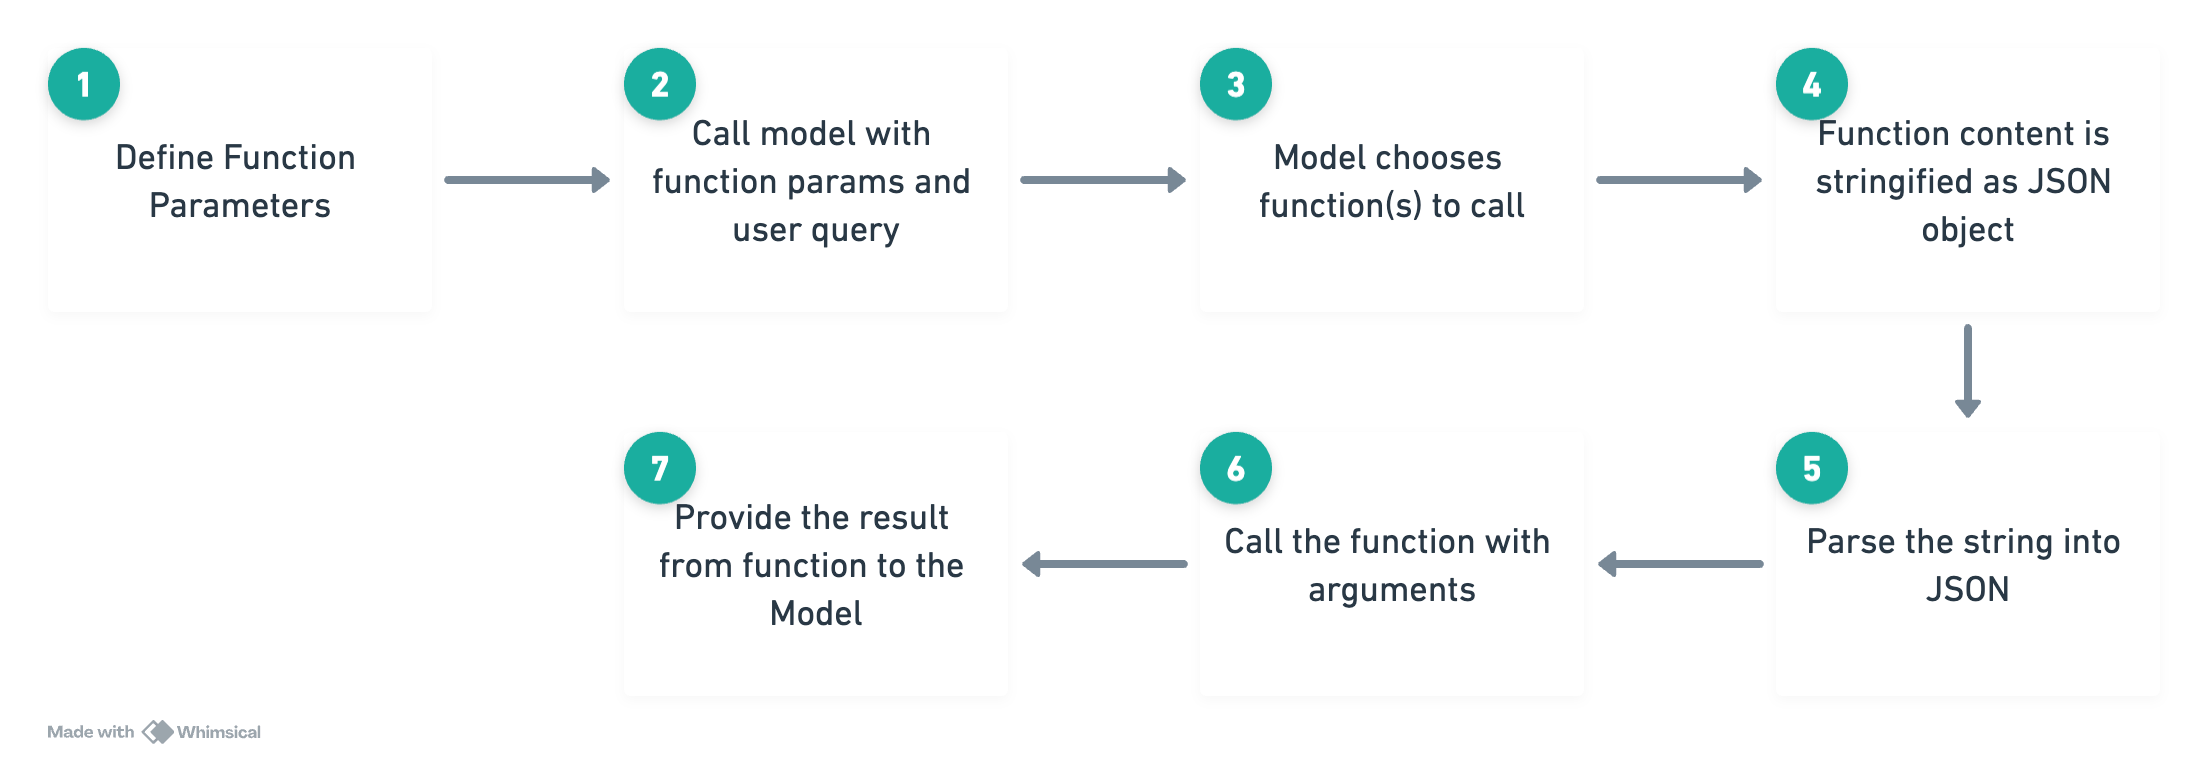

## Step 1
### Define function calling

A function has three main parameters:

- name: The name of the function that performs a certain task.
- description: Function description that describes what it does. The model uses this description paramter to determine when and how to call the function.
- parameters: A JSON schema object that describes the parameters that the function accepts. For function that doesn't accept any parameters, pass empty dict as value for parameters property.

In [ ]:
def get_country_stats(population, capital):
  return population, capital

In [22]:
fn_tools = [
    {
        "type": "function",
        "function": {
            "name": "get_country_stats",
            "description": "Get the statistics of a country",
            "parameters": {
                "type": "object",
                "properties": {
                    "population": {
                        "type": "integer",
                        "description": "Population of the country."
                    },
                    "capital": {
                        "type": "string",
                        "description": "Capital of the country"
                    }
                },
                "required": ["population", "capital"]
            }
        }
    }
]

## 1. Data Extraction

Now, initiate GPT call with tools

In [23]:
prompt = "What is the population and capital of US?"

In [24]:
# Step 2: Call the model with function params and user query

response = client.chat.completions.create(
    model = MODEL,
    messages = [{
        "role": "user",
        "content": prompt
    }],
    tools=fn_tools, ## function params
    tool_choice="auto"
)

In [25]:
# Step 3: Model chooses function(s) to call
output = response.choices[0].message.tool_calls[0]

# Step 4: Function contents as JSON
print(output)


# Step 5: Parse the JSON
fn_name = output.function.name
arguments = json.loads(output.function.arguments)

print(fn_name)
print(arguments)

ChatCompletionMessageToolCall(id='call_5w2jAKPoTcKWk64PAlYFV8PZ', function=Function(arguments='{"population": 331449281, "capital": "Washington, D.C."}', name='get_country_stats'), type='function')
get_country_stats
{'population': 331449281, 'capital': 'Washington, D.C.'}


### Parallel Function Calling

Parallel function calling enables multiple functions to execute simultaneously, enhancing efficiency and reducing API latency, particularly for time-consuming operations.

In [ ]:
prompt = "What is the population and capital of Nepal, France, and the UK?"

In [ ]:
# Step 2: Call the model with function params and user query

response = client.chat.completions.create(
    model = MODEL,
    messages = [{
        "role": "user",
        "content": prompt
    }],
    tools=fn_tools, ## function params
    tool_choice="auto"
)

In [ ]:
# Step 3: Model chooses function(s) to call
output = response.choices[0].message.tool_calls

# Step 4: Function contents as JSON
print(output)


# Step 5: Parse the JSON
for out in output:
  fn_name = out.function.name
  arguments = json.loads(out.function.arguments)

  print(fn_name)
  print(arguments)

[ChatCompletionMessageToolCall(id='call_Jh9onlWiwzmia3qHFTUkG2Vv', function=Function(arguments='{"population": 30000000, "capital": "Kathmandu"}', name='get_country_stats'), type='function'), ChatCompletionMessageToolCall(id='call_cCrvVOK9NUl5fzuuMPB1PhU0', function=Function(arguments='{"population": 67000000, "capital": "Paris"}', name='get_country_stats'), type='function'), ChatCompletionMessageToolCall(id='call_fvlKQOQ0DzquN3eXLsjVZVVO', function=Function(arguments='{"population": 66000000, "capital": "London"}', name='get_country_stats'), type='function')]
get_country_stats
{'population': 30000000, 'capital': 'Kathmandu'}
get_country_stats
{'population': 67000000, 'capital': 'Paris'}
get_country_stats
{'population': 66000000, 'capital': 'London'}


### 2. Code Execution

**Security Warning**: Be cautious when using exec() and eval(), especially with untrusted input. These functions can execute arbitrary code, which might be a significant security risk.

In [ ]:
fn_tools = [
    {
        "type": "function",
        "function": {
            "name": "exec_code",
            "description": "Execute the code returned by GPT model.",
            "parameters": {
                "type": "object",
                "properties": {
                    "code": {
                        "type": "string",
                        "description": "Code in string returned by GPT model."
                    }
                },
            "required": ["code"]
            }
        }
    }
]


def exec_code(code):
  try:
    exec(code, globals())
  except Exception as e:
    raise e

In [ ]:
prompt = "Write a Python function to calculate and print the given numbers of the Fibonacci sequence"


In [ ]:
response = client.chat.completions.create(
    model = MODEL,
    messages = [{
        "role": "user",
        "content": prompt
    }],
    tools=fn_tools,
    tool_choice={"type": "function", "function": {"name": "exec_code"}},

)

In [ ]:
res = response.choices[0].message
tool_calls = res.tool_calls

In [ ]:
tool_calls

[ChatCompletionMessageToolCall(id='call_SQ5mONfzcNIef2L8QXtYV8F5', function=Function(arguments='{"code":"def fibonacci_sequence(n):\\n    fib_sequence = [0, 1]\\n    for i in range(2, n):\\n        next_number = fib_sequence[i-1] + fib_sequence[i-2]\\n        fib_sequence.append(next_number)\\n    return fib_sequence"}', name='exec_code'), type='function')]

In [ ]:
fn = eval(tool_calls[0].function.name)
args = json.loads(tool_calls[0].function.arguments)

fn(**args)

In [ ]:
fibonacci_sequence(12)

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89]

## 3. Database Information Retrieval

In [ ]:
import pandas as pd

In [ ]:
url = 'https://www.dropbox.com/scl/fi/9gedcvinwkzeoo8ujy9i8/supermarket_sales.csv?rlkey=vzepsac9g1nus7blvysi0p1ah&dl=1'
data = pd.read_csv(url)
data


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2/9/2019,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2/22/2019,15:33,Cash,65.82,4.761905,3.2910,4.1


In [ ]:
df_fn_tools = [
    {
        "type": "function",
        "function": {
            "name": "retrieve_top_rated_stores",
            "description": "Retrieve given number of top rated stores",
            "parameters": {
                "type": "object",
                "properties": {
                    "n": {
                        "type": "integer",
                        "description": "The number of top rated stores to find"
                    }
                },
                "required": ["n"]
            }

        }
    },
    {
        "type": "function",
        "function": {
            "name": "retrieve_total_sales_by_branch",
            "description": "Retrieve total sales for the given branch",
            "parameters": {
                "type": "object",
                "properties": {
                    "Branch": {
                        "type": "string",
                        "description": "The name of the branch"
                    }
                },
                "required": ["Branch"]
            }
        }
    }
]


def retrieve_top_rated_stores(n:int):
  top_n = data.sort_values(by="Rating", ascending=False).head(n)
  return top_n

In [ ]:
prompt = "What's the top rated store?"
# prompt = "What're the top 3 rated store"

In [ ]:
messages = [{"role":"user", "content": prompt }]

response = client.chat.completions.create(
    model = MODEL,
    messages = messages,
    tools=df_fn_tools,
    tool_choice = "auto"
)

In [ ]:
output = response.choices[0].message.tool_calls[0]
df_fn = eval(output.function.name) ## danger zone
args = json.loads(output.function.arguments)

In [ ]:
# Step 6: Call the function with argument
fn_res = df_fn(**args)
print(fn_res)
fn_res = fn_res.to_json()

      Invoice ID Branch      City Customer type  Gender  \
387  725-56-0833      A    Yangon        Normal  Female   
159  423-57-2993      B  Mandalay        Normal    Male   
853  866-70-2814      B  Mandalay        Normal  Female   

               Product line  Unit price  Quantity  Tax 5%    Total       Date  \
387       Health and beauty       32.32        10  16.160  339.360  2/20/2019   
159       Sports and travel       93.39         6  28.017  588.357  3/27/2019   
853  Electronic accessories       52.79        10  26.395  554.295  2/25/2019   

      Time      Payment    cogs  gross margin percentage  gross income  Rating  
387  16:49  Credit card  323.20                 4.761905        16.160    10.0  
159  19:18      Ewallet  560.34                 4.761905        28.017    10.0  
853  11:58      Ewallet  527.90                 4.761905        26.395    10.0  


In [ ]:
response

ChatCompletion(id='chatcmpl-97BcDMLAxpSF0mJj6c0Z7v1gd9c77', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_w4DXMa3xap6ezU12nTy24EiS', function=Function(arguments='{"n":3}', name='retrieve_top_rated_stores'), type='function')]))], created=1711499973, model='gpt-3.5-turbo-1106', object='chat.completion', system_fingerprint='fp_89448ee5dc', usage=CompletionUsage(completion_tokens=18, prompt_tokens=103, total_tokens=121))

In [ ]:
# Step 7 :provide the result from function to the model
messages = [{"role":"user", "content": prompt }]
messages.append({
    "role": response.choices[0].message.role,
    "content": str(response.choices[0].message.tool_calls[0].function)
})
messages.append(
    {"role": "function",
     "tool_call_id": output.id,
     "name": output.function.name,
     "content": fn_res
     }
)

print(messages)

[{'role': 'user', 'content': "What're the top 3 rated store"}, {'role': 'assistant', 'content': 'Function(arguments=\'{"n":3}\', name=\'retrieve_top_rated_stores\')'}, {'role': 'function', 'tool_call_id': 'call_w4DXMa3xap6ezU12nTy24EiS', 'name': 'retrieve_top_rated_stores', 'content': '{"Invoice ID":{"387":"725-56-0833","159":"423-57-2993","853":"866-70-2814"},"Branch":{"387":"A","159":"B","853":"B"},"City":{"387":"Yangon","159":"Mandalay","853":"Mandalay"},"Customer type":{"387":"Normal","159":"Normal","853":"Normal"},"Gender":{"387":"Female","159":"Male","853":"Female"},"Product line":{"387":"Health and beauty","159":"Sports and travel","853":"Electronic accessories"},"Unit price":{"387":32.32,"159":93.39,"853":52.79},"Quantity":{"387":10,"159":6,"853":10},"Tax 5%":{"387":16.16,"159":28.017,"853":26.395},"Total":{"387":339.36,"159":588.357,"853":554.295},"Date":{"387":"2\\/20\\/2019","159":"3\\/27\\/2019","853":"2\\/25\\/2019"},"Time":{"387":"16:49","159":"19:18","853":"11:58"},"Paym

In [ ]:
analyse_response = client.chat.completions.create(
    model = MODEL,
    messages = messages
)


In [ ]:
analyse_response.choices[0].message.content

'The top 3 rated stores are:\n\n1. Store with Invoice ID 725-56-0833 in Yangon\n2. Store with Invoice ID 423-57-2993 in Mandalay\n3. Store with Invoice ID 866-70-2814 in Mandalay'

# Build an Assistant

1. What is an Assistant API?

According to OpenAI, it allows you to build an AI assistant that has instructions and uses models, tools, and knowledge to answer queries.

Assistant API currently supports 3 types of tools:
- Code Interpreter: allow us to write
- Retrieval
- Function Calling



In [ ]:
import requests

def ask_ares(query: str) -> str:

    api_key = userdata.get("ARES_API_KEY")

    if not api_key:
      raise ValueError("API key for ARES is missing.")

    headers = {
      "x-api-key": api_key,
      "content-type": "application/json"
    }

    url = "https://api-ares.traversaal.ai/d/predict"
    data = { "data": [query] }

    try:
      response = requests.post(url, json=data, headers=headers, timeout=20)

      json_str = json.dumps(response.json(), indent=4)

      return json_str

    except requests.exceptions.RequestException as e:
      return f"Failed to fetch recommendations."



In [ ]:
import time
import json
import sys

def get_response(run, client, thread):
    print("Initial Status:", run.status)

    while run.status in ['queued', 'in_progress', 'cancelling']:

        time.sleep(0.2)

        if run.status != 'in_progress':
          print(f"Current Status: {run.status}")

        elif run.status == 'in_progress':
          print('.', end='', flush=True)
          time.sleep(0.2)


        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)

        if run.status == 'requires_action':
            run = handle_requires_action(run, client, thread)

        elif run.status == 'failed':
            print("\nRun failed.")
            return

        elif run.status == 'completed':
            print("\nRun completed.")
            display_messages(client, thread)
            return

def handle_requires_action(run, client, thread):
    tool_responses = []
    if run.required_action.type == 'submit_tool_outputs' and run.required_action.submit_tool_outputs.tool_calls:
        for call in run.required_action.submit_tool_outputs.tool_calls:
            if call.type == "function":

                fn_call = getattr(sys.modules["__main__"], call.function.name, None)
                if fn_call:
                    args = json.loads(call.function.arguments)
                    tool_res = fn_call(**args)
                    tool_responses.append({"tool_call_id": call.id, "output": tool_res})

    return client.beta.threads.runs.submit_tool_outputs(thread_id=thread.id, run_id=run.id, tool_outputs=tool_responses)

def display_messages(client, thread):
    messages = client.beta.threads.messages.list(thread_id=thread.id).data
    for msg in reversed(messages):
        role_prefix = red("User: ", 'bold') if msg.role == "user" else green("Assistant: ", 'bold')
        print(role_prefix + " ".join(mc.text.value for mc in msg.content))



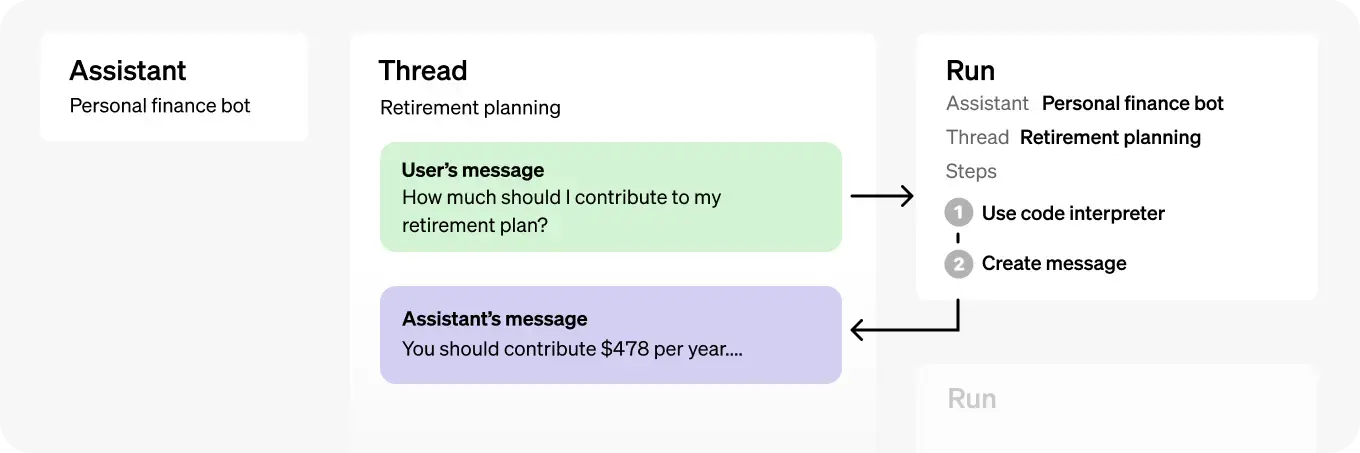


<small sytle="right: 0px">Source: OpenAI</small>


To build an Assistant API, we have to follow a few steps:
1. Create an Assistant with instructions and enable the type of assistant it is.
2. Create a Thread. Thread is a conversation between a user and assistant(s).
3. Add Message to the thread. You can add text or files in the message and there's no limit to number of messages in the thread.
4. Run the thread. This will use the model and tools to generate a response. All responses are added to the thread as assistant message.

In [ ]:
question = "I need help traveling to Nepal"
# ask_ares(question)

### Run a conversation with the assistant

There are 3 main items to consider when running Assistant.

- **Assitant**: This sets the model, instructions, tool, and context to use for the conversation
- **Threads**: Represents the state of a conversation
- **Runs**: executes a thread

In [ ]:
assistants = client.beta.assistants.list()

names = [(d.id, d.name) for d in assistants.data]

for id, name in names:
  if name == 'Personal Assistant':
    print(name)
    ## delete the assistant
    response = client.beta.assistants.delete(assistant_id=id)
    print(response)

    ## or alternatively, retrieve the assistant,
    # assistant = client.beta.assistants.retrieve(assistant_id=id)

Personal Assistant
AssistantDeleted(id='asst_sRvseihpUGrFpxzcutSzlxdk', deleted=True, object='assistant.deleted')


## How to create an Assistant

There are only 3 things we need:

1. Give instructions and tell assistant what to do.
2. Use tools to add capabilities. Max number of tools allowed is 128 tools. We can use a combination of code interpreter, retrieval, or any custom functions.
3. model name

In [ ]:
## Create an assistant

assistant = client.beta.assistants.create(
    model = MODEL,
    name = "Personal Assistant",
    instructions = "You are a helpful assistant. Before answering question, make sure to understand the question and requirements. Ask questions to gather as much information as needed to get the most accurate answer, but do not ask it all at the same time.",
    tools = [{
        "type": "function",
        "function": {
            "name": "ask_ares",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "Query asked by human to get answer from ARES"
                      }
                },
                "required": ["query"]
            },
            "description": "Find me the best answer or suggestions based on my query"
            }
        }], ## additional items for other functions like { "type": "code_interpreter "}

)

In [ ]:
## create a thread
## represents a conversation with one or many assistants.
## create a thread when a conversation is started with the assistant
thread = client.beta.threads.create()

In [ ]:
## message contents are as Message object in the thread
## message can contain file or text, and there are no limit to the number of message
## any messages larger than the context window are truncated
message = client.beta.threads.messages.create(
    thread_id = thread.id,
    role = "user",
    content = question
)

In [ ]:
## create run
## after all messages are added to the thread, it can be run
## creating the run uses the model and tools
## all runs are added to the thread as assistant messages
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
)

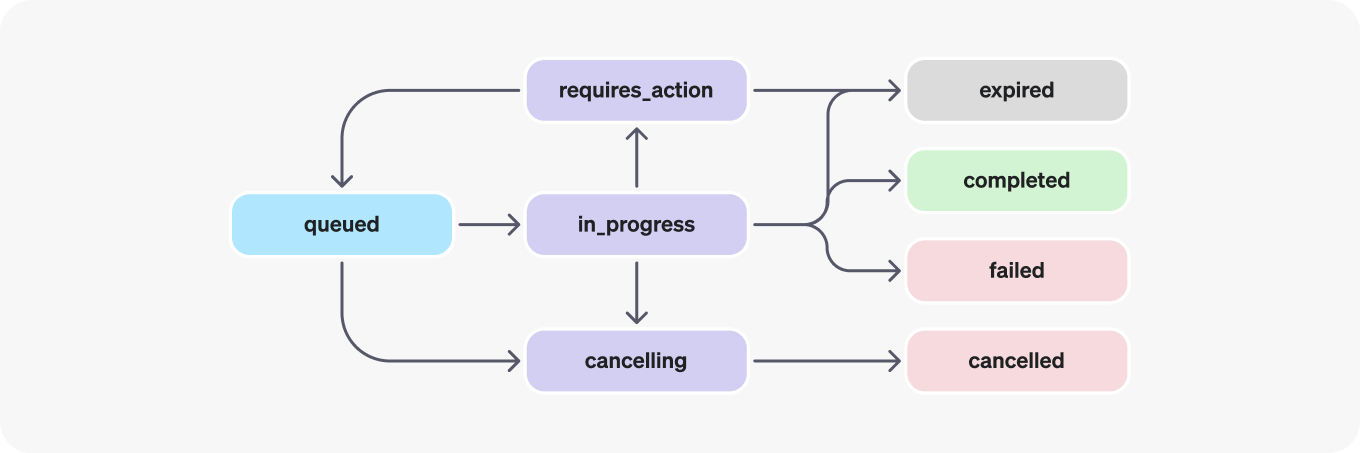

<small>Source: OpenAI</small>

In [ ]:
get_response(run, client, thread)

Initial Status: queued
Current Status: queued
<function ask_ares at 0x791c12e8d240>
Current Status: queued
Current Status: queued
.........................................................................................................................................................................................................
Run completed.
User: I need help traveling to Nepal
Assistant: Nepal is a country known for its natural beauty, rich cultural heritage, and adventure opportunities. Here is a summary of information to help you plan your trip:

1. Passport and Visa: Ensure your passport is valid for at least six months beyond your planned stay. You will need a visa to enter Nepal, which can be obtained from the country's embassy or nearest consulate prior to your visit.

2. Safety: While Nepal is generally safe for tourists, it is recommended to exercise caution and stay updated on the current travel advisories. It is advisable not to trek or climb alone and to use a local guid

In [ ]:
## message contents are as Message object in the thread
## message can contain file or text, and there are no limit to the number of message
## any messages larger than the context window are truncated
message = client.beta.threads.messages.create(
    thread_id = thread.id,
    role = "user",
    content = "What about accommodations?"
)

In [ ]:
## create run
## after all messages are added to the thread, it can be run
## creating the run uses the model and tools
## all runs are added to the thread as assistant messages
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
)

In [ ]:
get_response(run, client, thread)

Initial Status: queued
Current Status: queued
...........................................................
Run completed.
User: I need help traveling to Nepal
Assistant: Nepal is a country known for its natural beauty, rich cultural heritage, and adventure opportunities. Here is a summary of information to help you plan your trip:

1. Passport and Visa: Ensure your passport is valid for at least six months beyond your planned stay. You will need a visa to enter Nepal, which can be obtained from the country's embassy or nearest consulate prior to your visit.

2. Safety: While Nepal is generally safe for tourists, it is recommended to exercise caution and stay updated on the current travel advisories. It is advisable not to trek or climb alone and to use a local guide or porter for safety.

3. Best Time to Visit: The best time to visit Nepal is during the Autumn months of September to November and the Spring months of March to May. These seasons offer pleasant weather, clear skies, and vi

## How to create an Assistant (cntd..)

In addition to above, we can also add an optional parameter `file_ids` to give access to files.

But, before Assitant can use files, it must be first uploaded using File Upload endpoint.

Max info:
- 20 files per Assistant
- <=512 MB each
- must be <= 100 GB in total per organization.


#### Upload file

In [7]:
## download an example file

from google.colab import files

## original URL: https://www.sciencedirect.com/science/article/pii/S1936878X20300954?via%3Dihub. Elsevier blocks file downloads using script

!wget -O example.pdf https://www.dropbox.com/scl/fi/y4o2uddef73nogpjx5lln/1-s2.0-S1936878X20300954-main.pdf?rlkey=pujaa3m056fk0imyn8tz9nb3j&dl=1


--2024-03-31 13:36:16--  https://www.dropbox.com/scl/fi/y4o2uddef73nogpjx5lln/1-s2.0-S1936878X20300954-main.pdf?rlkey=pujaa3m056fk0imyn8tz9nb3j
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc52082ca1fda88e5c270b66cf14.dl.dropboxusercontent.com/cd/0/inline/CQJMo2ZwXSYghOzMKKNgfg787amBoGDFSBGQjdsq4d_zxIWO_5dFwXO5kLPuf8HptEEd5ZMEnuCzW1ut3kOMxWUMmklYUEJKnvx2AdPNEfEPCIDRA8LvQK56ZChwfFkgksk/file# [following]
--2024-03-31 13:36:17--  https://uc52082ca1fda88e5c270b66cf14.dl.dropboxusercontent.com/cd/0/inline/CQJMo2ZwXSYghOzMKKNgfg787amBoGDFSBGQjdsq4d_zxIWO_5dFwXO5kLPuf8HptEEd5ZMEnuCzW1ut3kOMxWUMmklYUEJKnvx2AdPNEfEPCIDRA8LvQK56ZChwfFkgksk/file
Resolving uc52082ca1fda88e5c270b66cf14.dl.dropboxusercontent.com (uc52082ca1fda88e5c270b66cf14.dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:601b:15::a27d:80f


In [ ]:
from openai import OpenAI
from google.colab import userdata

MODEL = 'gpt-3.5-turbo-1106'
client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY')
)

In [ ]:

file_response = client.files.create(
        file=open("example.pdf", "rb"),
        purpose="assistants" ## must be one of 'fine-tune', 'assistants', 'batch', 'user_data'
      )
print(file_response.id)

file-DMn1ZaffU9NLVwu62ETFAQ3T


In [ ]:
assistant = client.beta.assistants.create(
    model = MODEL,
    name = "Paper Reviewer",
    instructions = "You are a helpful cardiology researcher. I will ask you questions about patient similarity in cardiac function and you will answer it in as much details as possible. You can use the documents I provide to you to help you answer the questions. If you are not 100% sure, you can say `I don't know`, but do not make up your answer.",
    tools = [{ "type": "retrieval" }]
)

In [ ]:

assistant_file = client.beta.assistants.files.create(
  assistant_id=assistant.id,
  file_id=file_response.id
)



In [ ]:
question = "What is the main objective of applying unsupervised machine-learning techniques to echocardiographic features according to the study?"
# question = "Can you describe how the patient similarity network was validated and the generalizability of the model tested according to the document?"
# question = "What were the significant findings of the study in relation to MACE-related hospitalization and death?"
# question = "Discuss the potential clinical implications and limitations of the study as outlined in the document."

In [ ]:
thread = client.beta.threads.create()

message = client.beta.threads.messages.create(
    thread_id = thread.id,
    role = "user",
    content = question
)

run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
)

In [ ]:
get_response(run, client, thread)

Initial Status: queued
Current Status: queued

Run completed.
User: What is the main objective of applying unsupervised machine-learning techniques to echocardiographic features according to the study?
Assistant: The main objective of applying unsupervised machine-learning techniques to echocardiographic features, according to the study, was to integrate these features into a patient similarity network that could predict major adverse cardiac events (MACE) in an individual patient【7†source】.


In [ ]:
question = "How were patients classified or grouped in the study, and what were the key echocardiographic features used?"

message = client.beta.threads.messages.create(
    thread_id = thread.id,
    role = "user",
    content = question
)

run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
)

get_response(run, client, thread)

Initial Status: queued
Current Status: queued
.....................................................
Run completed.
User: What is the main objective of applying unsupervised machine-learning techniques to echocardiographic features according to the study?
Assistant: The main objective of applying unsupervised machine-learning techniques to echocardiographic features, according to the study, was to integrate these features into a patient similarity network that could predict major adverse cardiac events (MACE) in an individual patient【7†source】.
User: How were patients classified or grouped in the study, and what were the key echocardiographic features used?
Assistant: Patients in the study were classified into distinct groups using a network-based community detection algorithm, which allowed for the identification of patient clusters based on similar echocardiographic features. The key echocardiographic features used to evaluate cardiac function included the assessment of left ventricul